In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.linalg
import scipy.fftpack
import math
import time

In [3]:
df = pd.read_csv("../sampledata/shuttle.csv")
data = df["0"]

# df = pd.read_csv("../sampledata/uci_retail_cleaned.csv")
# data = df["x"]

# df = pd.read_csv("../sampledata/occupancy_2.csv")
# data = df["CO2"]

In [4]:
x_min = np.min(data)
x_max = np.max(data)
data = (data - x_min)
data = data / np.max(data)
data = (data-.5)*2

k=11
p_gen = np.polynomial.chebyshev.Chebyshev
# Polynomial Basis
p_basis = [p_gen.basis(deg=i) for i in range(2*k)]
# Dataset Moments
d_mus = np.array([
    np.mean(p(data)) for p in p_basis
])
# print(repr(d_mus))

In [13]:
# Clenshaw-Curtis Quadrature (see Numerical recipes 5.9.1)
def fit_cpoly(f, tol=1e-10):
    c_k = 64
    while True:
        xvals = np.cos(np.linspace(0,math.pi,c_k+1))
        fvals = f(xvals)
        cs = scipy.fftpack.dct(fvals, type=1) / c_k
        # Last term of the expansion is an error bound
        if cs[-1] < tol:
            break
        else:
            c_k *= 2
    cs[0] *= .5
    return cs
def calc_mus(f, mu_k, tol=1e-10):
    f_coeffs = fit_cpoly(f, tol)
    f_cp = p_gen(f_coeffs)
    mus = [
        (f_cp * p_basis[i]).integ(lbnd=-1)(1)
        for i in range(mu_k)
    ]
    return np.array(mus)

def gen_pdf(lambd):
    cp = p_gen(lambd)
    def pdf(x):
        return np.exp(-cp(x))
    return pdf
def calc_quantile(lambd, p, tol=1e-10):
    cp = p_gen(fit_cpoly(gen_pdf(lambd), tol=tol))
    cp_integral = cp.integ(lbnd=-1) - p
    val = scipy.optimize.brentq(
        f=cp_integral,
        a=-1,
        b=1,
        xtol=tol,
    )
    return val

In [14]:
# See newton's method in boyd's convex optimization for importance of step size backtracking
def step_backtrack(func, x0, dx, f0, df0):
    alpha = .3
    beta = .25
    t = 1.0
    f1 = func(x0+t*dx)
    while f1 > f0 + alpha*t*np.inner(df0, dx):
        t *= beta
        f1 = func(x0+t*dx)
    return t
def newton2(data_mus, max_steps=100):
    k = len(data_mus)
    # Convex potential function P 
    # which has a minimum and gradient 0 when the moments match
    def P(lambd):
        f_pdf = gen_pdf(lambd)
        f_mus = calc_mus(f_pdf, 1)
        return f_mus[0] + np.inner(lambd, data_mus)

    cur_lambd = np.zeros(k)
    steps = 0
    while True:
        pdf = gen_pdf(cur_lambd)
        e_mus = calc_mus(pdf, 2*k)
        f0 = e_mus[0] + np.inner(cur_lambd, data_mus)
        dlambda = data_mus - e_mus[:k]
#         print("dlambda: {}".format(dlambda))
        if np.max(dlambda) < 1e-10:
            return cur_lambd
        # Derivative of chebyshev polynomial
        hh = np.array([[
            (e_mus[i+j] + e_mus[abs(i-j)])*.5
            for i in range(k)
        ] for j in range(k)])
        lambda_step = scipy.linalg.solve(
            hh,
            -dlambda,
            assume_a="pos",
            overwrite_a=True
        )
        t = step_backtrack(
            P, 
            x0=cur_lambd, dx=lambda_step, 
            f0=f0, df0=dlambda
        )
#         print("t: {}".format(t))
        
        cur_lambd += t*lambda_step
        steps += 1
        if steps > max_steps:
            return cur_lambd

In [16]:
start_time = time.time()
lambd_maxent = newton2(d_mus[:11])
elapsed = time.time() - start_time
print(elapsed)

0.19356799125671387


In [17]:
p=.5
sdata = np.sort(data)
est_q = calc_quantile(lambd_maxent, p, tol=1e-5)
est_q_cdf = np.searchsorted(sdata, est_q) / len(sdata)
est_q_error = est_q_cdf - p
q = np.percentile(data, p*100)
print("Estimated p{}: {}".format(p,est_q))
print("True p{}: {}".format(p,q))
print("Quantile Error: {}".format(est_q_error))

Estimated p0.5: -0.601806923807564
True p0.5: -0.6363636363636364
Quantile Error: 0.04163218390804602


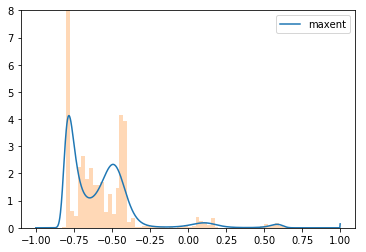

In [18]:
xs = np.linspace(-1,1,1000)
f0 = gen_pdf(lambd_maxent)
y0 = [f0(x) for x in xs]
plt.plot(xs, y0, label="maxent")
_ = plt.hist(data, density=True, bins=80, alpha=.3)
plt.ylim(0,8)
plt.legend()